In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import *
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv("uber.csv")
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [24]:
def read_data(path:str)->pd.DataFrame:
    df = pd.read_csv(path)
    return df

def basic_info(df:pd.DataFrame)->pd.DataFrame:
    return df.info()

def extract_distance(longitude1:np.ndarray,latitiude1:np.ndarray,longitude2:np.ndarray,latitude2:np.ndarray)->list:
    distance =[]
    #Calculating great circle distance using haversine formula
    #iterating for each instance
    for pos in range(len(longitude1)):
        #converting into radian values
        long1,lat1,long2,lat2 = map(radians,[longitude1[pos],latitiude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lat = lat2 - lat1
        a = sin(dist_lat/2)**2 + cos(lat1)*cos(lat2)*sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        distance.append(c)
    return distance
    '''#using geopy
    distances =[]
    for pos in range(len(longitude1)):
        cord1 = (latitude1[pos],longitude1[pos])
        cord2 = (latitude2[pos],longitude2[pos])
        dist = geodesic(cord1,cord1).kilometers
        distances.append(dist)
    return distances
    '''

def outliers(df:pd.DataFrame)->pd.DataFrame:
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3 +1.5*IQR)))]
    
    return outliers

def preprocess(df:pd.DataFrame)->pd.DataFrame:
    
    df = df.drop(['Unnamed: 0', 'key'],axis =1)
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"],errors= "coerce")
    #drop missing instances
    df = df.dropna()
    df["distance_km"] = extract_distance(df['pickup_longitude'].to_numpy(), df['pickup_latitude'].to_numpy(),df['dropoff_longitude'].to_numpy(),df['dropoff_latitude'].to_numpy())
    
    df = df.assign(pickup_hr = df.pickup_datetime.dt.hour,
                  day = df.pickup_datetime.dt.day,
                  month = df.pickup_datetime.dt.month,
                  year = df.pickup_datetime.dt.year,
                  day_of_week = df.pickup_datetime.dt.dayofweek,
                  day_name = df.pickup_datetime.dt.day_name())
    
    fares_outliers = outliers(df["fare_amount"])
    print("Total no. of outliers in Fare amount: " + str(len(fares_outliers)))
    print("Max outlier value in Fares : " + str(fares_outliers.max()))
    print("Min outlier value in Fares : " + str(fares_outliers.min()))
    print("Outliers in Fare: ")
    print(fares_outliers)
          
    passengersCount_outliers = outliers(df["passenger_count"])
    print("Total no. of outliers in passenger count: " + str(len(passengersCount_outliers)))
    print("Max outlier value in passenger count : " + str(passengersCount_outliers.max()))
    print("Min outlier value in passenger count : " + str(passengersCount_outliers.min()))
    print("Outliers in passenger count: ")
    print(passengersCount_outliers)
    
          
    df.drop(df[df["distance_km"]==0].index,inplace= True)
    df.drop(df[df["distance_km"]>60].index,inplace= True)
    df.drop(df[df["fare_amount"]>100].index,inplace= True)
    df.drop(df[df["fare_amount"]<0].index,inplace= True)
    df.drop(df[df["passenger_count"]>6].index,inplace= True)

    return df


def visualize_corr(df:pd.DataFrame)->None:
          plt.figure(figsize=(10,7))
          sns.heatmap(df.corr(),annot=True)
          plt.show()
        
def split_data(df:pd.DataFrame)->tuple:
    x = df[["year","distance_km"]]
    y = df["fare_amount"]
    scaler = StandardScaler()
    scaler.fit_transform(x)
    
    X_train,Y_train,x_test,y_test = train_test_split(x,y,test_size=0.3, random_state=42)
    
    return X_train,Y_train,x_test,y_test

def create_model(model_name:str)->object:
    if model_name =="LR":
        model = LinearRegression()
    if model_name == "RF":
        model = RandomForestRegressor()
    return model

def train_model(model:object, X_train:np.ndarray,Y_train:np.ndarray)->None:
    model.fit(X_train,Y_train)

    
def test_model(model:object,x_test:np.ndarray)->np.ndarray:
    y_pred = model.predict(x_test)
    return y_pred

def metrics_model(y_test: np.ndarray, y_pred: np.ndarray) -> None:

    print(f"Mean absolute error {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"Mean squared error {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"Root mean squared error {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
    r_squared = metrics.r2_score(y_test, y_pred)
    print("R-squared (R^2):", r_squared)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
Total no. of outliers in Fare amount: 17166
Max outlier value in Fares : 499.0
Min outlier value in Fares : -52.0
Outliers in Fare: 
6         24.50
30        25.70
34        39.50
39        29.00
48        56.80
          ...  
199976    49.70
199977    43.50
199982    57.33
199985

C:\Users\vaio\AppData\Local\Temp\ipykernel_2272\4088769956.py:80: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


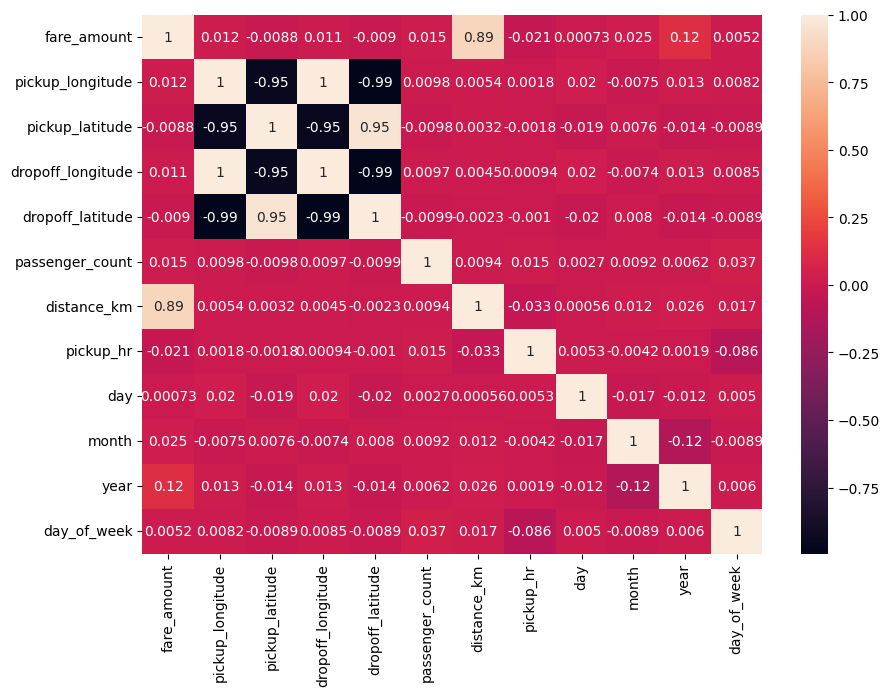


Model Metrics:

Mean absolute error 2.2438795034594725
Mean squared error 18.323819106454568
Root mean squared error 4.280633026370582
R-squared (R^2): 0.7933535173723434


In [25]:
df = read_data("uber.csv")
print(basic_info(df))
df = preprocess(df)
print("\n Correlation matrix \n")
visualize_corr(df)


In [28]:
x_train, x_test, y_train, y_test = split_data(df)
model = create_model("LR")
train_model(model, x_train, y_train)
y_pred = test_model(model, x_test)
print("\nModel Metrics:\n")
metrics_model(y_test, y_pred)


Model Metrics:

Mean absolute error 2.2438795034594725
Mean squared error 18.323819106454568
Root mean squared error 4.280633026370582
R-squared (R^2): 0.7933535173723434


In [29]:
x_train, x_test, y_train, y_test = split_data(df)
model = create_model("RF")
train_model(model, x_train, y_train)
y_pred = test_model(model, x_test)
print("\nModel Metrics:\n")
metrics_model(y_test, y_pred)


Model Metrics:

Mean absolute error 2.5014620560943825
Mean squared error 21.337355822356184
Root mean squared error 4.619237580202623
R-squared (R^2): 0.759368420761615
